### Detction de Cadastre

Les todo : 
- matching du cadastre sur sattelite ( gerer les translation, le zoom et la rotation )
- Detection de piscine sur l'image 
- comparer avec le cadastre 
- faire un flux API 

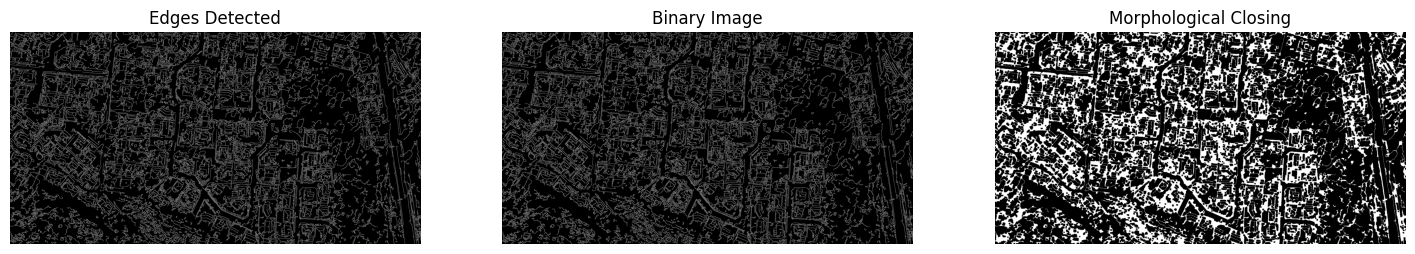

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image
file_path = 'Sattelite test.png'  # Replace with your image path
image = cv2.imread(file_path)

# Convert to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)

# Edge detection using Canny algorithm
edges = cv2.Canny(blurred, 50, 150)

# Apply binary threshold to get a binary image
_, binary_image = cv2.threshold(edges, 50, 255, cv2.THRESH_BINARY)

# Define a kernel for the morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))

# Morphological operations to close gaps in the road edges
closed = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)

# Display the processed images
plt.figure(figsize=(18, 9))

plt.subplot(1, 3, 1)
plt.imshow(edges, cmap='gray')
plt.title('Edges Detected')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(closed, cmap='gray')
plt.title('Morphological Closing')
plt.axis('off')

plt.show()


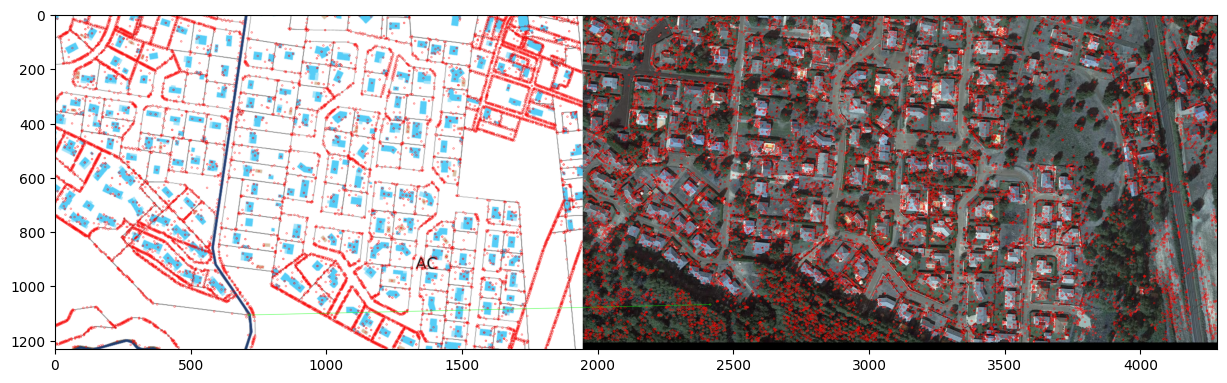

Not enough matches are found - 1/4


In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Paths to the input images
satellite_image_path = 'Sattelite test.png'
cadastre_image_path = 'Cadastre test.png'

# Load the images
satellite_image = cv2.imread(satellite_image_path)
cadastre_image = cv2.imread(cadastre_image_path)

# Convert images to grayscale
satellite_gray = cv2.cvtColor(satellite_image, cv2.COLOR_BGR2GRAY)
cadastre_gray = cv2.cvtColor(cadastre_image, cv2.COLOR_BGR2GRAY)

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints_satellite, descriptors_satellite = sift.detectAndCompute(satellite_gray, None)
keypoints_cadastre, descriptors_cadastre = sift.detectAndCompute(cadastre_gray, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(descriptors_cadastre, descriptors_satellite, k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# Ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)

# Draw the matches
img3 = cv2.drawMatchesKnn(cadastre_image, keypoints_cadastre, satellite_image, keypoints_satellite, matches, None, **draw_params)

plt.figure(figsize=(15, 7))
plt.imshow(img3)
plt.show()

# Proceed to compute homography and warp image if we have enough good matches
good_matches = [m for m, mask in zip(matches, matchesMask) if mask[0]]
if len(good_matches) > 4:  # Minimum number of matches to compute homography
    # Extract location of good matches
    points_cadastre = np.float32([keypoints_cadastre[m[0].queryIdx].pt for m in good_matches])
    points_satellite = np.float32([keypoints_satellite[m[0].trainIdx].pt for m in good_matches])

    # Find homography matrix
    H, status = cv2.findHomography(points_cadastre, points_satellite, cv2.RANSAC,5.0)

    # Warp cadastre image to fit satellite image
    height, width, channels = satellite_image.shape
    warped_cadastre = cv2.warpPerspective(cadastre_image, H, (width, height))

    plt.figure(figsize=(15, 7))
    plt.imshow(cv2.cvtColor(warped_cadastre, cv2.COLOR_BGR2RGB))
    plt.title("Warped Cadastre Image")
    plt.axis('off')
    plt.show()
else:
    print("Not enough matches are found - {}/{}".format(len(good_matches), 4))


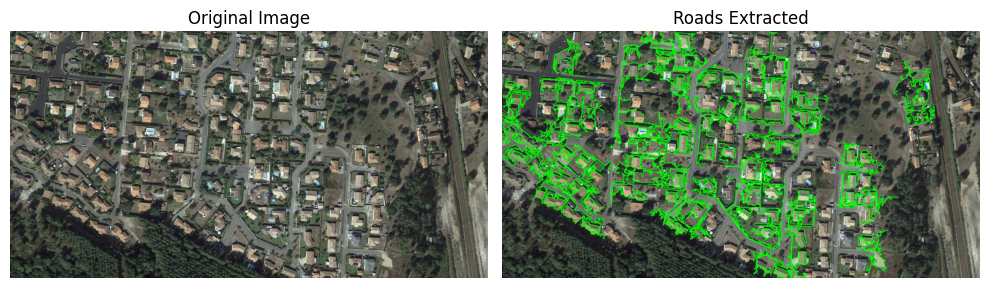

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image_path = 'Sattelite test.png'
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges using Canny
edges = cv2.Canny(blur, 50, 150)

# Dilate the edges
dilated = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)

# Erode to narrow the edges
eroded = cv2.erode(dilated, np.ones((2, 2), np.uint8), iterations=1)

# Find contours from the edged image
contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter the contours based on area (this might need to be adjusted)
road_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 3000]

# Draw the contours on the original image
road_img = np.copy(img)
cv2.drawContours(road_img, road_contours, -1, (0, 255, 0), 2)


# Let's display the original and the road extracted images side by side for comparison
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB))
plt.title('Roads Extracted')
plt.axis('off')

plt.tight_layout()
plt.show()

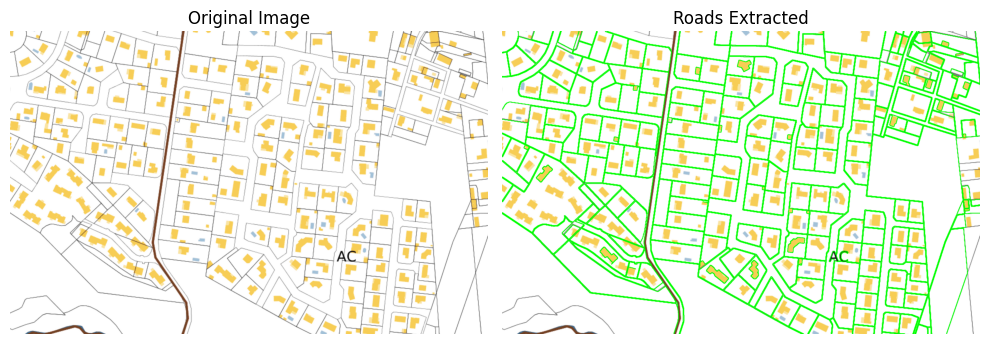

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image_path = 'Cadastre test.png'
img = cv2.imread(image_path)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply GaussianBlur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Detect edges using Canny
edges = cv2.Canny(blur, 50, 150)

# Dilate the edges
dilated = cv2.dilate(edges, np.ones((2, 2), np.uint8), iterations=1)

# Erode to narrow the edges
eroded = cv2.erode(dilated, np.ones((2, 2), np.uint8), iterations=1)

# Find contours from the edged image
contours, hierarchy = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Filter the contours based on area (this might need to be adjusted)
road_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1500]

# Draw the contours on the original image
road_img = np.copy(img)
cv2.drawContours(road_img, road_contours, -1, (0, 255, 0), 2)


# Let's display the original and the road extracted images side by side for comparison
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB))
plt.title('Roads Extracted')
plt.axis('off')

plt.tight_layout()
plt.show()



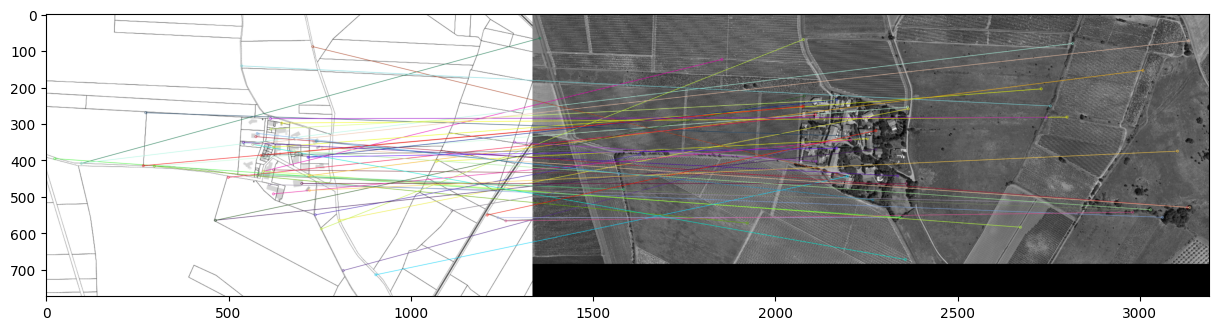

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
cadastre_path = 'Cadastre test 2.PNG'
satellite_path = 'Sattelite test 2.png'

cadastre_image = cv2.imread(cadastre_path, 0)  # Load in grayscale
satellite_image = cv2.imread(satellite_path, 0)  # Load in grayscale

# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features in both images
keypoints_cadastre, descriptors_cadastre = sift.detectAndCompute(cadastre_image, None)
keypoints_satellite, descriptors_satellite = sift.detectAndCompute(satellite_image, None)

# Create a Brute Force Matcher object
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Match descriptors
matches = bf.match(descriptors_cadastre, descriptors_satellite)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

# Draw the top N matches
N_MATCHES = 50
matched_image = cv2.drawMatches(cadastre_image, keypoints_cadastre, satellite_image, keypoints_satellite, matches[:N_MATCHES], None, flags=2)

# Display the matched features
plt.figure(figsize=(15, 8))
plt.imshow(matched_image)
plt.show()

# We will not proceed with finding the homography and warping the images due to potential scale and orientation differences that require manual input or advanced processing.


Not enough matches are found - 2/10


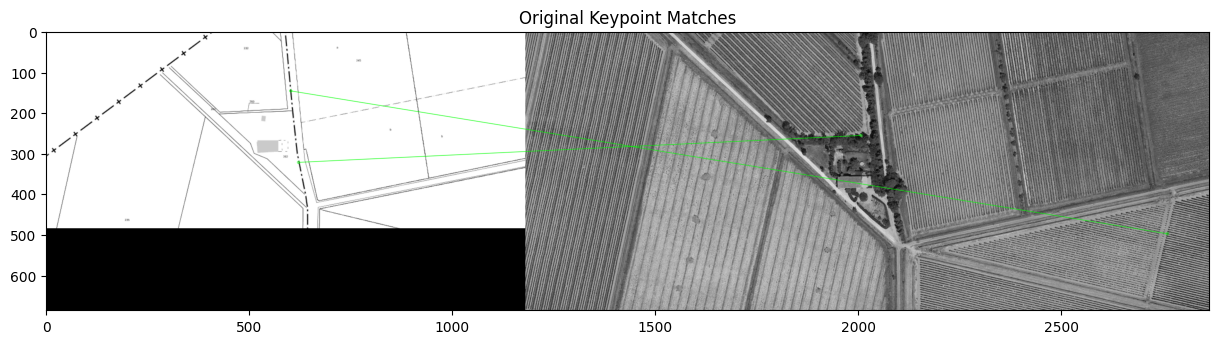

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the two images
image1_path = 'Cadastre test 3.PNG'
image2_path = 'Sattelite test 3.png'
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Convert images to grayscale
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

# Initialize the ORB detector
orb = cv2.ORB_create()

# Detect keypoints and descriptors
keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

# Initialize the matcher
# BFMatcher with default params
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# Homography if enough matches are found
if len(good) > 10:
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    # Calculate Homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Get the dimensions of the first image
    h, w = gray1.shape
    # Warp the second image to fit the first one
    warp_img = cv2.warpPerspective(image2, M, (w, h))

    # Show the aligned image
    plt.imshow(cv2.cvtColor(warp_img, cv2.COLOR_BGR2RGB))
    plt.title('Aligned Image')
    plt.show()
else:
    matchesMask = None
    print("Not enough matches are found - {}/{}".format(len(good), 10))

# Show original keypoint matches
draw_params = dict(matchColor=(0, 255, 0), # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask, # draw only inliers
                   flags=2)

img_matches = cv2.drawMatches(gray1, keypoints1, gray2, keypoints2, good, None, **draw_params)

# Show the 
plt.figure(figsize=(15, 8))
plt.imshow(img_matches)
plt.title('Original Keypoint Matches')
plt.show()


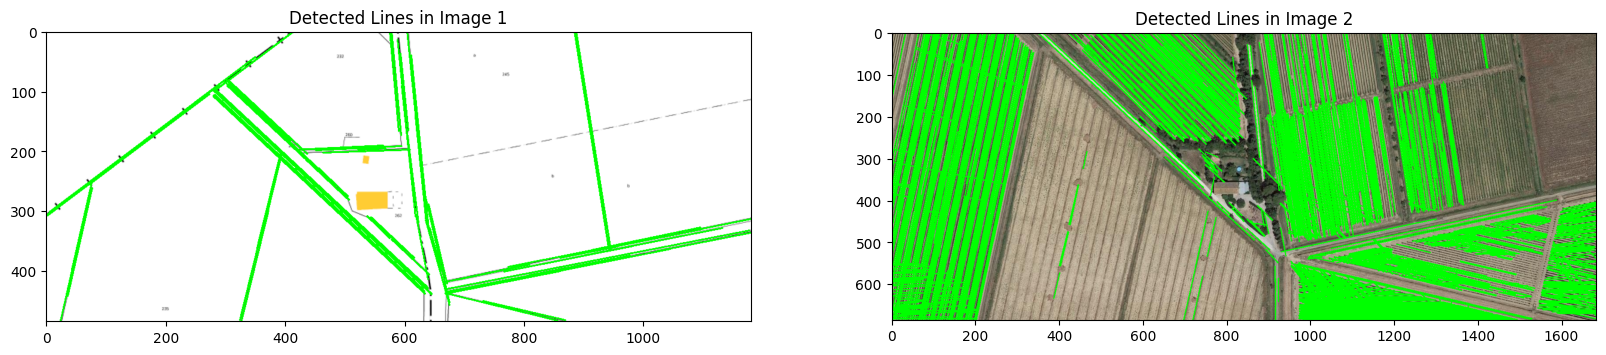

In [19]:
# Function to detect lines using Hough Transform
def detect_lines(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply GaussianBlur to reduce noise and improve edge detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    # Apply Canny edge detector
    edges = cv2.Canny(blurred, 50, 250, apertureSize=3)
    # Apply Hough Line Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=80, minLineLength=30, maxLineGap=10)
    return lines

# Draw lines detected by Hough Transform
def draw_lines(image, lines):
    line_image = image.copy()
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return line_image

# Detect lines in both images
lines1 = detect_lines(image1)
lines2 = detect_lines(image2)

# Draw the lines on the images
image1_with_lines = draw_lines(image1, lines1)
image2_with_lines = draw_lines(image2, lines2)

# Display the images with lines
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(cv2.cvtColor(image1_with_lines, cv2.COLOR_BGR2RGB))
axes[0].set_title('Detected Lines in Image 1')
axes[1].imshow(cv2.cvtColor(image2_with_lines, cv2.COLOR_BGR2RGB))
axes[1].set_title('Detected Lines in Image 2')
plt.show()


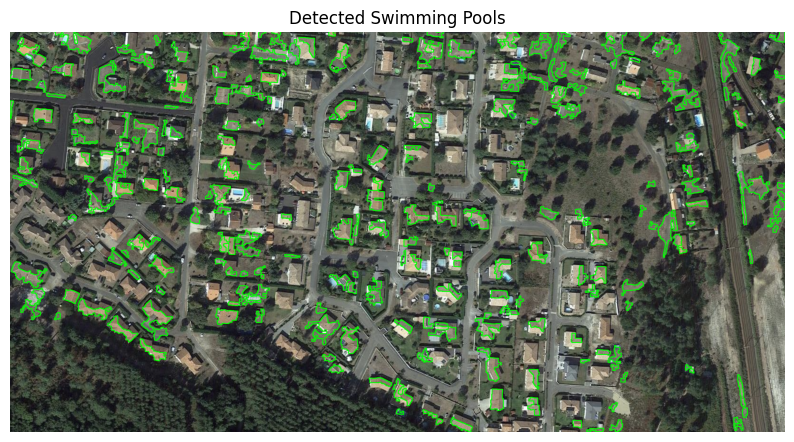

In [45]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the satellite image

image = cv2.imread(satellite_image_path)

# Convert the image to the HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the range for blue color typical for swimming pools
# These ranges can vary, might need tuning for the specific image
lower_blue = np.array([100, 50, 50])
upper_blue = np.array([140, 255, 255])

# Create a mask with the specified blue range
mask = cv2.inRange(image, lower_blue, upper_blue)

# Use morphological operations to clean up the mask
kernel = np.ones((5, 5), np.uint8)
mask_cleaned = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_OPEN, kernel)

# Find contours in the cleaned mask
contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on area and shape
pool_contours = []
for contour in contours:
    area = cv2.contourArea(contour)
    if area > 200 and area < 5000:  # Area threshold for pools, may need tuning
        perimeter = cv2.arcLength(contour, True)
        approximation = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
        if len(approximation) >= 4:
            pool_contours.append(contour)

# Draw the contours on the image
image_with_pools = image.copy()
cv2.drawContours(image_with_pools, pool_contours, -1, (0, 255, 0), 2)

# Show the result
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image_with_pools, cv2.COLOR_BGR2RGB))
plt.title('Detected houses')
plt.axis('off')
plt.show()


In [23]:
import folium
import json

# Load the GeoJSON data from a file
with open('cadastre-40160-communes.json', 'r') as file:
    geojson_data = json.load(file)

# Use Shapely to calculate the center of the bounding box
multi_polygon = shape(geojson_data['features'][0]['geometry'])
bounds = multi_polygon.bounds  # Returns (minx, miny, maxx, maxy)
center_x = (bounds[0] + bounds[2]) / 2
center_y = (bounds[1] + bounds[3]) / 2
center_point = (center_x, center_y)

center_point = (center_point[1],center_point[0])

In [1]:
import folium
import json
from shapely.geometry import shape

import branca

# Create a white image of 4 pixels, and embed it in a url.
white_tile = branca.utilities.image_to_url([[1, 1], [1, 1]])

# Load the GeoJSON data from a file
with open('cadastre-34130-parcelles.json', 'r') as file:
    geojson_data = json.load(file)

center_point = (43.523563486592614, 3.193477578841215)
# Create a folium map object
m = folium.Map(location=center_point, zoom_start=50, tiles=white_tile,attr="white tile")

# Add the GeoJSON data to the map
folium.GeoJson(geojson_data).add_to(m)

m

In [1]:
from ipyleaflet import Map, basemaps, basemap_to_tiles


center_point = (43.523563486592614, 3.193477578841215)

def create_satellite_view(latitude, longitude, zoom=18):
    satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)

    m = Map(center=(latitude, longitude), zoom=zoom)
    m.add_layer(satellite_layer)


    return m


latitude = center_point[0]
longitude = center_point[1]

# Display the map with satellite view
create_satellite_view(latitude, longitude)


Map(center=[43.523563486592614, 3.193477578841215], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
from ipyleaflet import Map, GeoJSON
import json

# Load the GeoJSON data from a file
with open('cadastre-34130-parcelles.json', 'r') as file:
    geojson_data = json.load(file)

center_point = (43.523563486592614, 3.193477578841215)
satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
# Create an ipyleaflet map object
m = Map(center=center_point, zoom=18)
m.add_layer(satellite_layer)
# Add the GeoJSON data to the map
geo_json_layer = GeoJSON(data=geojson_data)
m.add_layer(geo_json_layer)

# Display the map in the Jupyter Notebook
m

Map(center=[43.523563486592614, 3.193477578841215], controls=(ZoomControl(options=['position', 'zoom_in_text',…

- Notebook cadastre
- matching sattelite/cadastre/piscine

Code pour recuperer une image sattelite 

In [21]:
from ipyleaflet import Map, basemaps, basemap_to_tiles
from selenium import webdriver
import time 

name = "map_screen_test"
center_point = (43.523563486592614, 3.193477578841215)

def create_satellite_view(latitude, longitude, zoom=18):
    satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)

    m = Map(center=(latitude, longitude), zoom=zoom)
    m.add_layer(satellite_layer)


    return m


latitude = center_point[0]
longitude = center_point[1]

# Display the map with satellite view
m = create_satellite_view(latitude, longitude)
m.save(f"{name}.html")

driver = webdriver.Chrome()

# URL of the HTML file
url = f'file:///C:/Users/samue/Desktop/Life/CS/VIC/Projet_Final/{name}.html'

# Open the URL
driver.get(url)

time.sleep(10)

# Take screenshot
driver.save_screenshot("map.png")

# Close the browser
driver.quit()

In [ ]:
from ipyleaflet import Map, basemaps, basemap_to_tiles
from selenium import webdriver
import time 
from pools_detection import ColorPoolDetection
from PIL import Image
import cv2
import numpy as np
from ipyleaflet import Map, GeoJSON
import json

def save_sat_cad(center_point,name):
    # Load the GeoJSON data from a file
    with open('cadastre-34130-parcelles.json', 'r') as file:
        geojson_data = json.load(file)

    satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)
    # Create an ipyleaflet map object
    m = Map(center=center_point, zoom=18)
    m.add_layer(satellite_layer)
    # Add the GeoJSON data to the map
    geo_json_layer = GeoJSON(data=geojson_data)
    m.add_layer(geo_json_layer)

    m.save(f"{name}_with_cad.html")

def crop_image(input_path, crop_rectangle):
    with Image.open(input_path) as img:
        width, height = img.size
        crop_rectangle = (0, 0, width, height // 2)
        cropped_img = img.crop(crop_rectangle)
        return np.array(cropped_img)


def create_satellite_view(latitude, longitude, zoom=18):
        satellite_layer = basemap_to_tiles(basemaps.Esri.WorldImagery)

        m = Map(center=(latitude, longitude), zoom=zoom)
        m.add_layer(satellite_layer)

        return m

def cadastre_pool(center_point):
    name = "map_screen_test"
    
    latitude = center_point[0]
    longitude = center_point[1]

    # Display the map with satellite view
    m = create_satellite_view(latitude, longitude)
    m.save(f"{name}.html")

    print("----------------Load cadastre------------")
    save_sat_cad(center_point,name)

    driver = webdriver.Chrome()

    # URL of the HTML file
    url1 = f'file:///C:/Users/samue/Desktop/Life/CS/VIC/Projet_Final/{name}.html'
    url2 = f'file:///C:/Users/samue/Desktop/Life/CS/VIC/Projet_Final/{name}_with_cad.html'
    # Open the URL
    driver.get(url1)
    time.sleep(10)


    print("----------------Take a screen------------")
    # Take screenshot
    driver.save_screenshot("map.png")


    # Open the URL
    driver.get(url2)
    time.sleep(10)


    print("----------------Take a screen------------")
    # Take screenshot
    driver.save_screenshot("cad.png")


    # Close the browser
    driver.quit()
    
    # Example usage
    input_image_path = 'map.png'
    cad_image_path = 'cad.png'

    crop_rectangle = (100, 100, 400, 400) 

    image = crop_image(input_image_path, crop_rectangle)
    cad = crop_image(cad_image_path, crop_rectangle)
    print("----------------Detect pools------------")
    # pools detection 
    pools_detection = ColorPoolDetection(image)
    pools = pools_detection.filter_and_draw_polygons(show=False)

    # draw houses and pools
    contour_img = cad.copy()
    cv2.drawContours(contour_img, pools, -1, (0, 0, 255), 2)

    plt.figure(figsize=(12, 12))
    plt.imshow(contour_img)
    plt.title('Image with Filtered Polygons')
    plt.axis('off')
    plt.show()


center_point = (43.5229915797976, 3.1898024073627718)
cadastre_pool(center_point)